## learning-AI101 : diabetes regression
### 당뇨 데이터를 polynomial regression, ridge, lasso를 이용하여 regression

<br>

- **임규연 (lky473736)**
- 2024.07.23. ~ 2024.07.24.에 문서 작성
- **dataset** : https://github.com/plotly/datasets/blob/master/diabetes.csv
- **kaggle** : https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data
- **data abstract** : This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

------

- **CAUTION : `./classification_diabetes.ipynb`에서 본 데이터로 이미 EDA를 진행하였기 때문에 regression을 할 이 파일에서는 EDA를 생략한다. 바로 아래에 파일을 연 후 전처리 단계부터 진행할 예정이다.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

----

### 1. 파일 열기 및 데이터 준비, 전처리

아래를 고려하여 본 과정을 진행한다.

- 본 regression에서는 input을 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age'으로, target을 'BMI'로 선정한다. 또한 기존 target인 'Outcome' 열을 삭제하자.
- 또한, EDA 과정에서 BMI와 상관계수가 높았던 feature만 feature selection을 통하여 데이터를 추린 후, polynormial regression을 진행할 예정이다. 특성공학을 적용하지 않은 원본 feature과 특성공학을 적용한 feature를 비교할 예정. feature selection한 X_train_fs_scaled를 추가적으로 준비할 것이다.

In [2]:
# 파일 열기

df = pd.read_csv('./data/diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# df의 info 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Outcome 열 드랍

df = df.drop('Outcome', axis=1)
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [8]:
# 나머지 attribute에 대한 feature, input split 

diabetes_input = df[['Pregnancies', 'Glucose', 'BloodPressure', 
                     'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']].to_numpy()
diabetes_target = df['BMI'].to_numpy()

diabetes_input.shape, diabetes_target.shape

((768, 7), (768,))

In [9]:
# X_train, y_train, X_test, y_test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes_input, 
                                                   diabetes_target,
                                                   test_size=0.2)

In [10]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

BMI와 상관계수가 높은 feature은 아래와 같다.

- **SkinThickness (상관계수 0.39)**
    - 체지방량이 증가하면 피부 두께도 증가할 가능성이 큼. 
    - BMI는 체지방을 반영하는 지표
- **Insulin (상관계수 0.33)**
    - BMI가 높은 사람은 대개 인슐린 저항성이 높고, 이에 따라 혈중 인슐린 수치도 높을 수 있음
- **Glucose (상관계수 0.22)**
    - 비만은 종종 인슐린 저항성과 관련이 있다고 알려져 있음.
    - BMI가 높으면 당뇨병 위험이 증가할 수 있으므로, 혈당 수치와 어느 정도 상관관계를 보인다고 할 수 있음

따라서 위 3개의 feature을 feature selection하여 추후 polynormial regression 시 기존 score와 비교해보도록 하자.
    


In [12]:
# 번외 : 추후 사용할 data (feature selection)
# 사용할 feature : SkinThickness, Insulin, Glucose

diabetes_input_fs = df[['SkinThickness', 'Insulin', 'Glucose']].to_numpy() 

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(diabetes_input_fs, diabetes_target,  
                                                    test_size=0.2)

ss_transformer = StandardScaler()
ss_transformer.fit(X_train_fs)

X_train_fs_scaled = ss_transformer.transform(X_train_fs)
X_test_fs_scaled = ss_transformer.transform(X_test_fs)

추가적으로 feature을 증강한 데이터를 학습시켰을 때 score 또한 비교할 것이니, 아래와 같은 과정을 거져 X_train_poly_scaled까지 준비한다.

In [33]:
# PolynormialFeatures으로 특성 늘리기 -> 스케일링

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

ss_transformer = StandardScaler()
ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)

shape | X_train_poly : (614, 36), X_test_poly : (154, 36)
poly | ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3'
 'x0 x4' 'x0 x5' 'x0 x6' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x1 x6'
 'x2^2' 'x2 x3' 'x2 x4' 'x2 x5' 'x2 x6' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6'
 'x4^2' 'x4 x5' 'x4 x6' 'x5^2' 'x5 x6' 'x6^2']


-------

### 2. 각종 모델을 적용하여 regression
- polynomial regression, ridge, lasso을 이용한 regression
- 순서는 아래와 같이 진행
    - **(1) polynormial regression**
        - (1-1) X_train_scaled, X_test_scaled로 진행
        - (1-2) X_train_fs_scaled, X_test_fs_scaled로 진행
        - (1-3) X_train_poly_scaled, X_test_poly_scaled로 진행
        - (1-4) 적합한 회귀 모델 foundation을 위한 모델 별 simulation 
    - **(2) ridge**
        - (2-1) alpha값을 grid search를 통해 hyperparameter tuning, 시각화
        - (2-2) alpha값을 random search를 통해 hyperparameter tuning, 시각화
    - **(3) lasso**
        - (3-1) alpha값을 grid search를 통해 hyperparameter tuning, 시각화
        - (3-2) alpha값을 random search를 통해 hyperparameter tuning, 시각화

#### 1) polynormial regression
- 다항 회귀는 LinearRegression을 사용한다.

#### (1-1) X_train_scaled, X_test_scaled로 진행

In [47]:
# modelling, fit, score을 한번에

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit (X_train_scaled, y_train)

score1 = [lr.score(X_train_scaled, y_train), lr.score(X_test_scaled, y_test)]
print (f"train score, test score : {score1}")

train score, test score : [0.2328907262433051, 0.1812092391171134]


#### (1-2) X_train_fs_scaled, X_test_fs_scaled로 진행

In [48]:
# modelling, fit, score을 한번에

lr = LinearRegression()
lr.fit (X_train_fs_scaled, y_train_fs)

score2 = [lr.score(X_train_fs_scaled, y_train_fs), lr.score(X_test_fs_scaled, y_test_fs)]
print (f"train score, test score : {score1}")

train score, test score : [0.2328907262433051, 0.1812092391171134]


#### (1-3) X_train_poly_scaled, X_test_poly_scaled로 진행

In [49]:
# modelling, fit, score을 한번에

lr = LinearRegression()
lr.fit (X_train_poly_scaled, y_train)

score3 = [lr.score(X_train_poly_scaled, y_train), lr.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {score1}")

train score, test score : [0.2328907262433051, 0.1812092391171134]


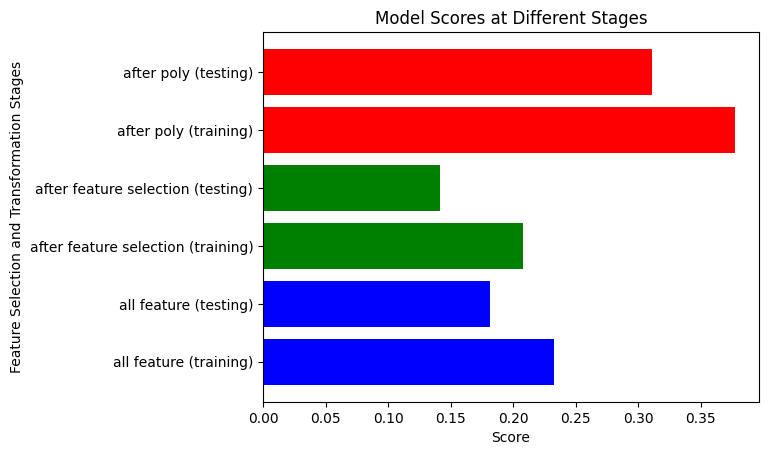

In [50]:
# 여태껏 각 score 시각화

labels = [
    'all feature (training)',
    'all feature (testing)',
    'after feature selection (training)',
    'after feature selection (testing)',
    'after poly (training)',
    'after poly (testing)'
]

scores = [score1[0], score1[1], score2[0], score2[1], score3[0], score3[1]]

plt.barh(labels, scores, color=['blue', 'blue', 'green', 'green', 'red', 'red'])

plt.xlabel('Score')
plt.ylabel('Feature Selection and Transformation Stages')
plt.title('Model Scores at Different Stages')

plt.show()

**현재 세 data set을 fit한 결과는 매우 형편없다.** 전체적으로 train score가 굉장히 낮아 overfitting되고 있는 상황이다. 이에 대한 원인을 추측해보면 아래와 같다.

- (1) 선형 회귀 모델이 매우 단순하다는 것을 고려하였을 때, 데이터의 복잡한 패턴을 제대로 잡아내지 못하는 것 같다.
- (2) 데이터 자체가 비선형적이기에 그렇다고 생각이 드는데, polynormial regression의 고유식 자체가 다항식이라서 이건 원인이 될 수가 없다.

위 두 근거를 바탕으로, 본 데이터를 학습시키기에 적합한 모델을 찾기 위해 아래 과정을 실시한다.

#### (1-4) 적합한 회귀 모델 foundation을 위한 모델 별 simulation
- Linear Regression, Ridge, Lasso, RandomForestRegressor, GradientBoostingRegressor을 적용하여 score가 어떻게 나오는 지를 확인
- 각 모델의 hyperparameter은 재량껏 정함

In [45]:
# 모델 별 simulation

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

models = {
    "linear regression": LinearRegression(),
    "ridge": Ridge(alpha=1.0),
    "lasso": Lasso(alpha=1.0),
    "random forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "gradient boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# X_train_poly_scaled, X_test_poly_scaled을 사용
for name, model in models.items() :
    model.fit(X_train_poly_scaled, y_train)
    train_score = model.score(X_train_poly_scaled, y_train)
    test_score = model.score(X_test_poly_scaled, y_test)
    print(f"{name} - Train score: {train_score:.4f}, Test score: {test_score:.4f}")

linear regression - Train score: 0.3779, Test score: 0.3108
ridge - Train score: 0.3769, Test score: 0.3104
lasso - Train score: 0.2149, Test score: 0.2111
random forest - Train score: 0.9034, Test score: 0.4031
gradient boosting - Train score: 0.7560, Test score: 0.3980


**전체적으로 점수가 그리 좋지 않다.** 따라서 본 regression 문서에서는 score에 집중하는 것이 아닌, 각 모델간의 score의 변화나 모델의 구동 양상을 파악하는 것으로 초점을 두겠다.

#### 2) ridge
- L2 규제 (제곱항의 sumation)을 통한 feature control을 진행
- grid search와 random search를 통한 최적의 alpha값을 찾을 것임

#### (2-1) grid search

In [69]:
# ridge 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 grid search 기법 사용

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {'alpha': np.logspace(-3, 3, 50)}

gs = GridSearchCV(ridge, param_grid, cv=5, n_jobs=-1)
gs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {gs.best_params_}')
print(f'cross-validation score : {gs.best_score_}')

최적의 hyperparameter : {'alpha': 33.9322177189533}
cross-validation score : 0.22450440966258114


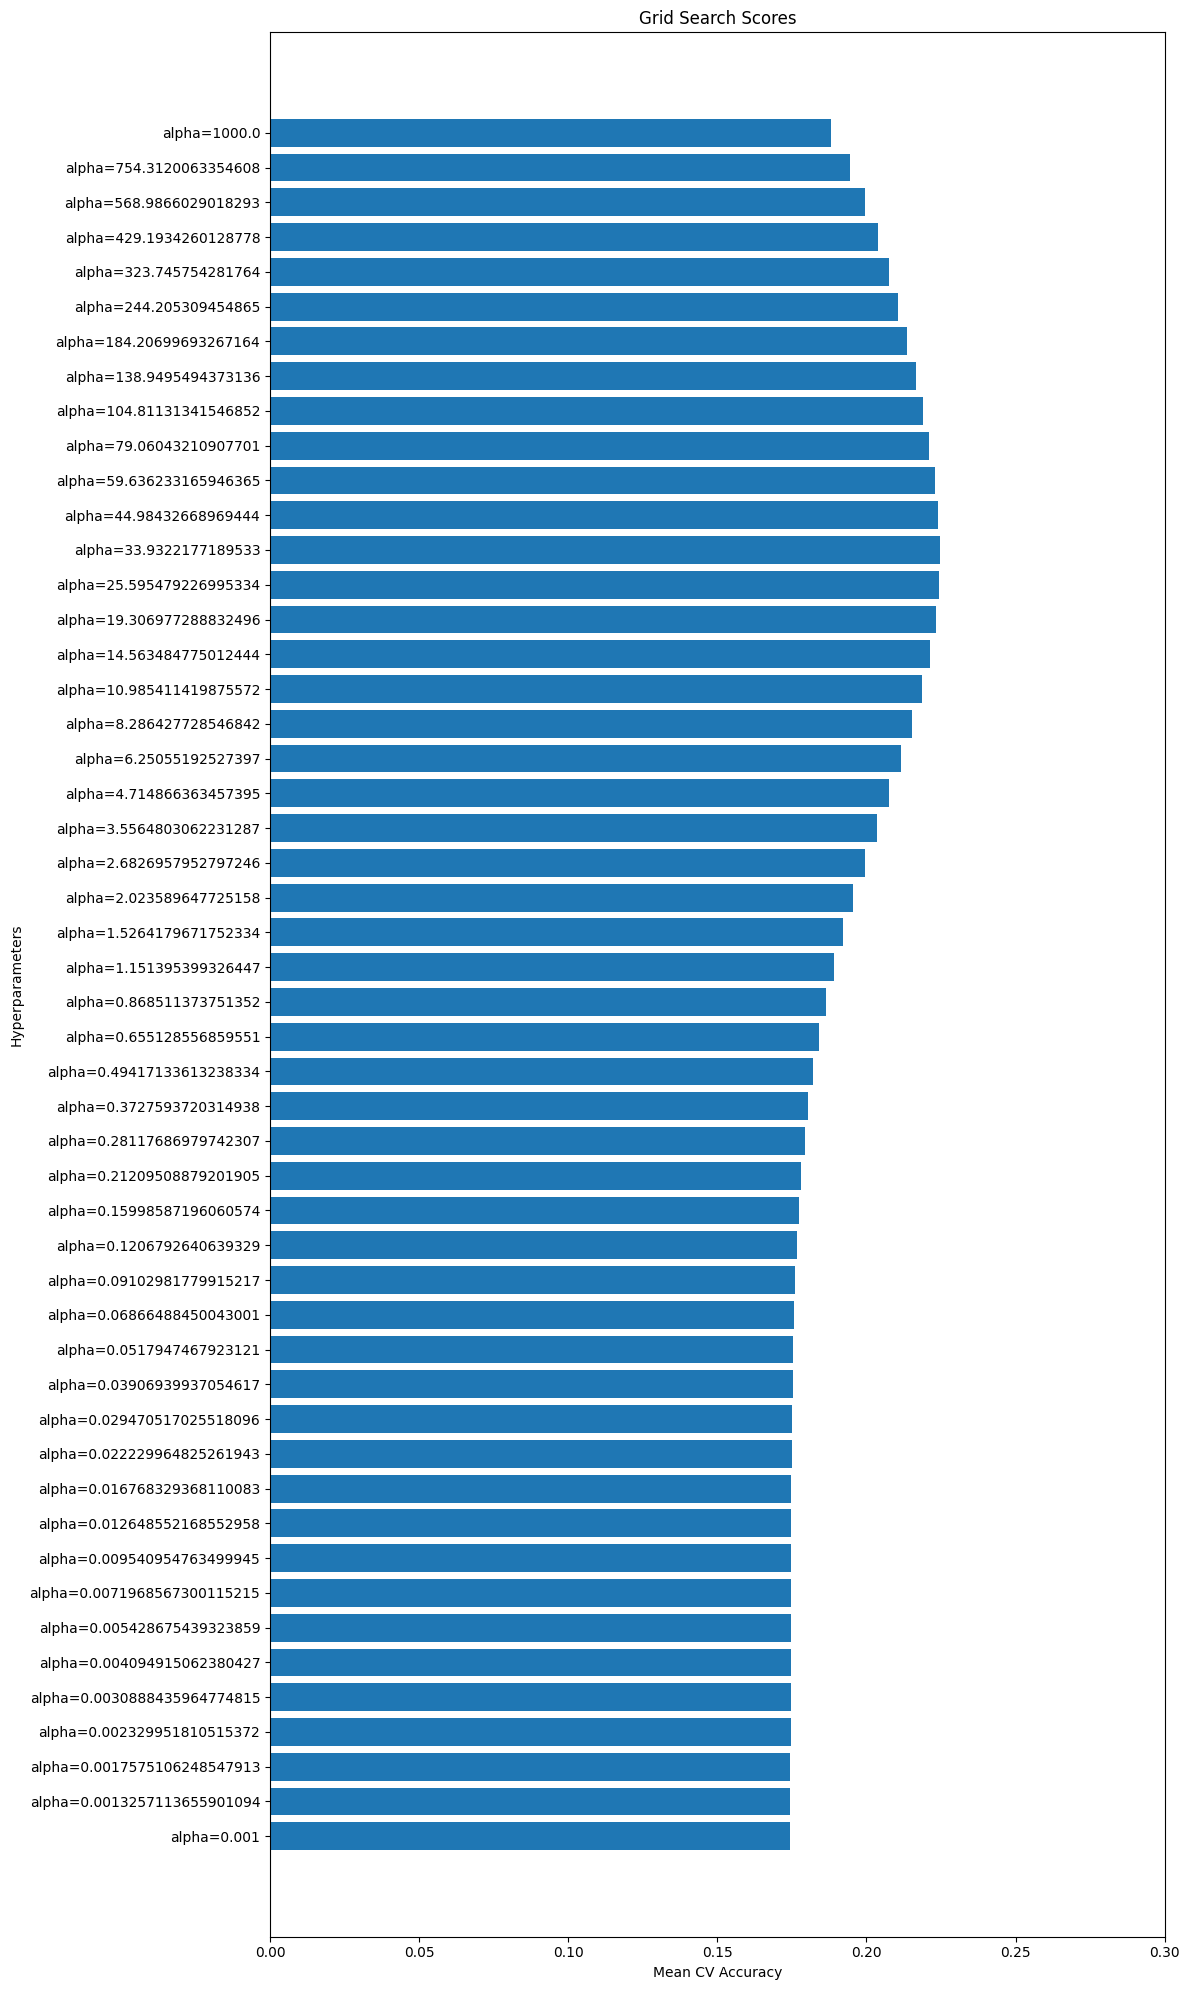

In [70]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = gs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Scores')
plt.xlim([0, 0.3])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

최적의 hyperparameter는 'alpha': 33.9322177189533인 것을 확인 가능하며, best_estimator로 최적의 모델을 추출 후 train score, test score을 측정한다.

In [71]:
ridge = gs.best_estimator_
ridge_score = [ridge.score(X_train_poly_scaled, y_train), ridge.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {ridge_score}")

train score, test score : [0.32730937516359737, 0.29353663055601364]



#### (2-2) random search

In [60]:
# ridge 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 random search 기법 사용

from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

ridge = Ridge()

param_grid = {'alpha': uniform(0, 1000)}

rs = RandomizedSearchCV(ridge, param_grid, n_iter=100, n_jobs=-1)
rs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {rs.best_params_}')
print(f'cross-validation score : {rs.best_score_}')

최적의 hyperparameter : {'alpha': 38.53897059986977}
cross-validation score : 0.22436662675037788


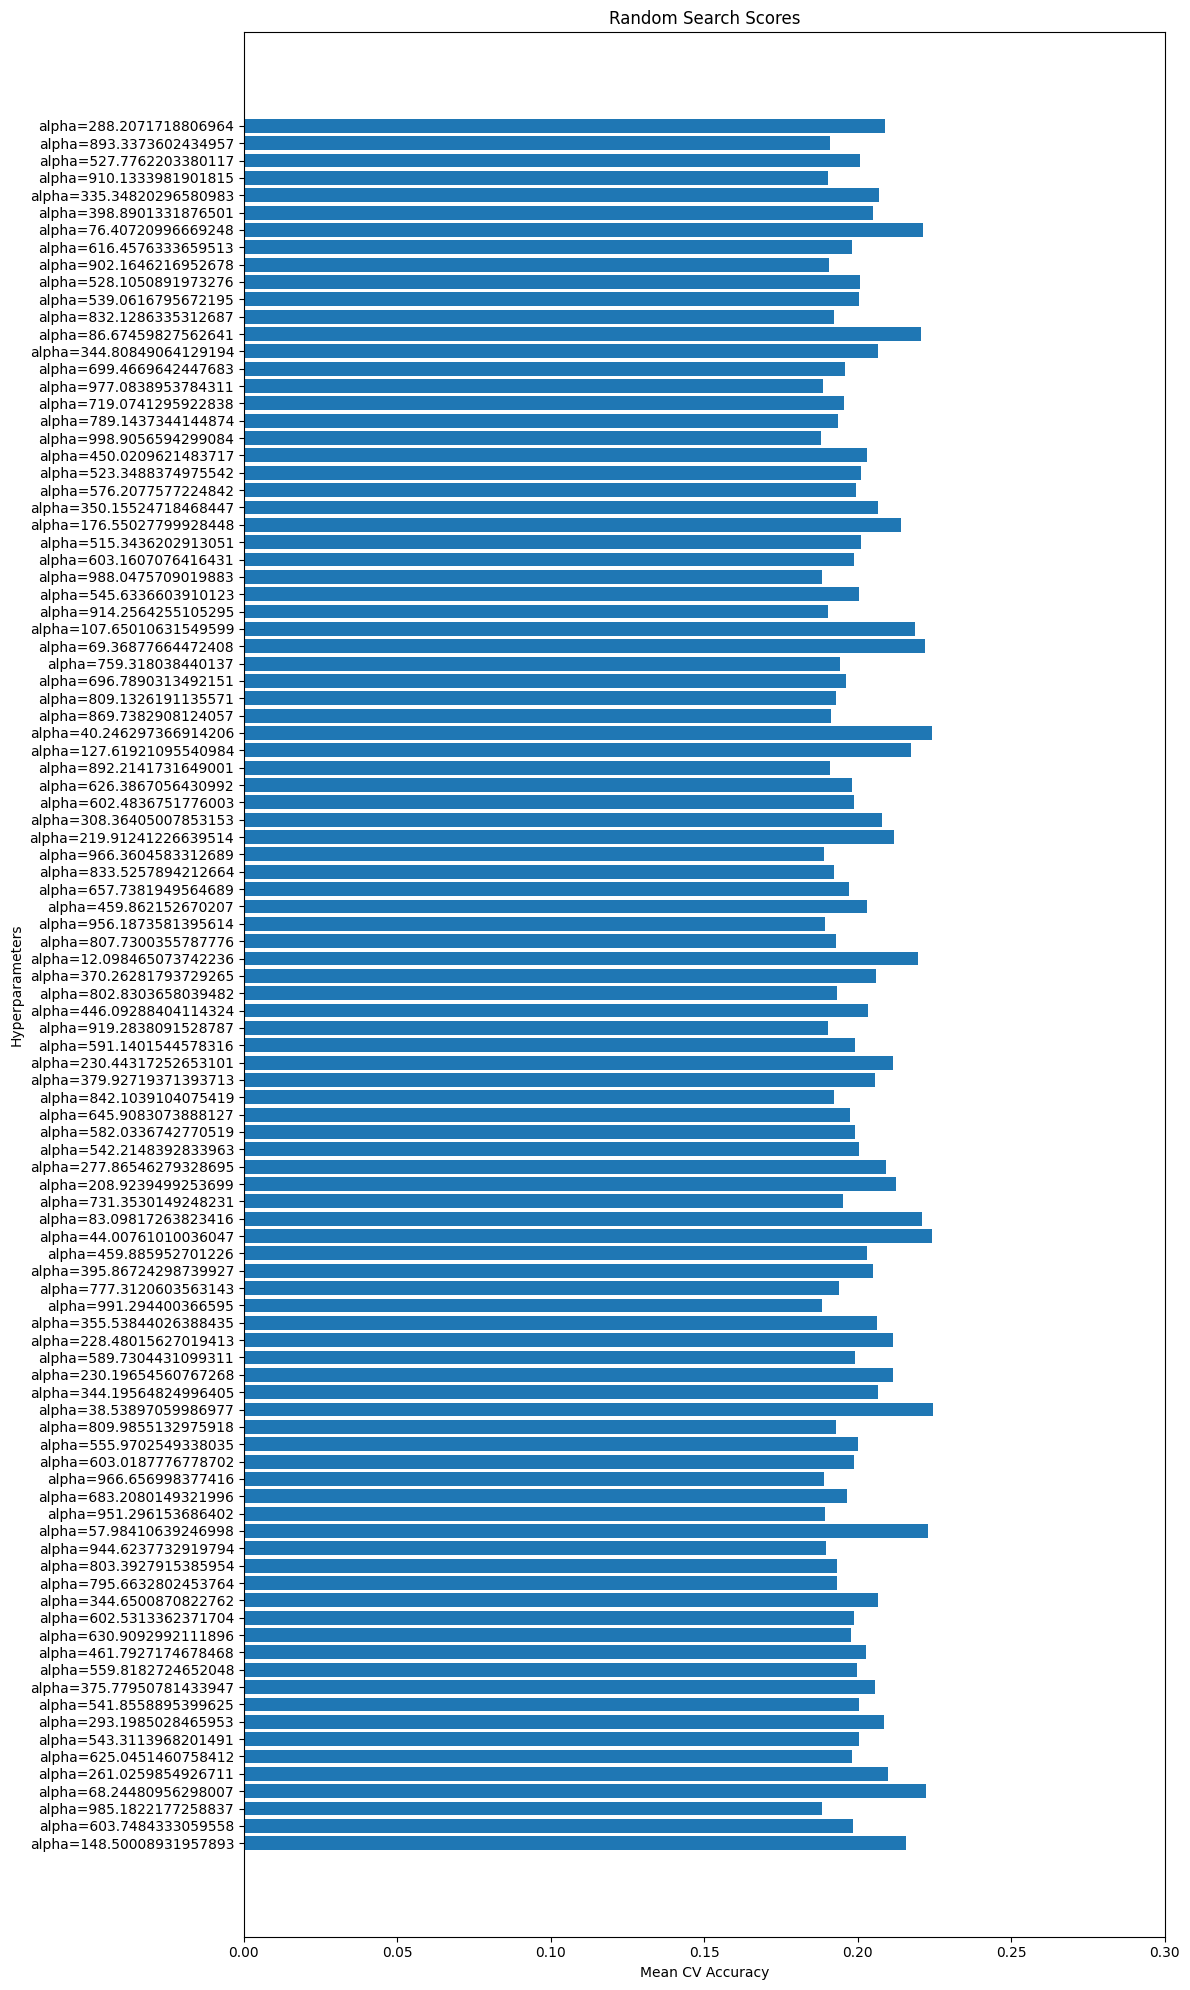

In [62]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim([0, 0.3])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

meter는 'alpha': 38.53897059986977인 것을 확인 가능하며, best_estimator로 최적의 모델을 추출 후 train score, test score을 출력한다.

In [72]:
ridge = rs.best_estimator_
# lr.fit (X_train_poly_scaled, y_train)

ridge_score = [ridge.score(X_train_poly_scaled, y_train), ridge.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {ridge_score}")

train score, test score : [0.32334697874907536, 0.2912127795599184]


#### 3) lasso
- L1 규제 (절댓값 항의 sumation)을 통한 feature control을 진행
- grid search와 random search를 통한 최적의 alpha값을 찾을 것임

#### (3-1) grid search

In [65]:
# lasso 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 grid search 기법 사용

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(max_iter=1000)

param_grid = {'alpha': np.logspace(-3, 3, 50)}

gs = GridSearchCV(lasso, param_grid, cv=5, n_jobs=-1)
gs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {gs.best_params_}')
print(f'cross-validation score : {gs.best_score_}')

최적의 hyperparameter : {'alpha': 0.21209508879201905}
cross-validation score : 0.19357504950514953


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.340e+01, tolerance: 3.230e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.553e+01, tolerance: 2.948e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

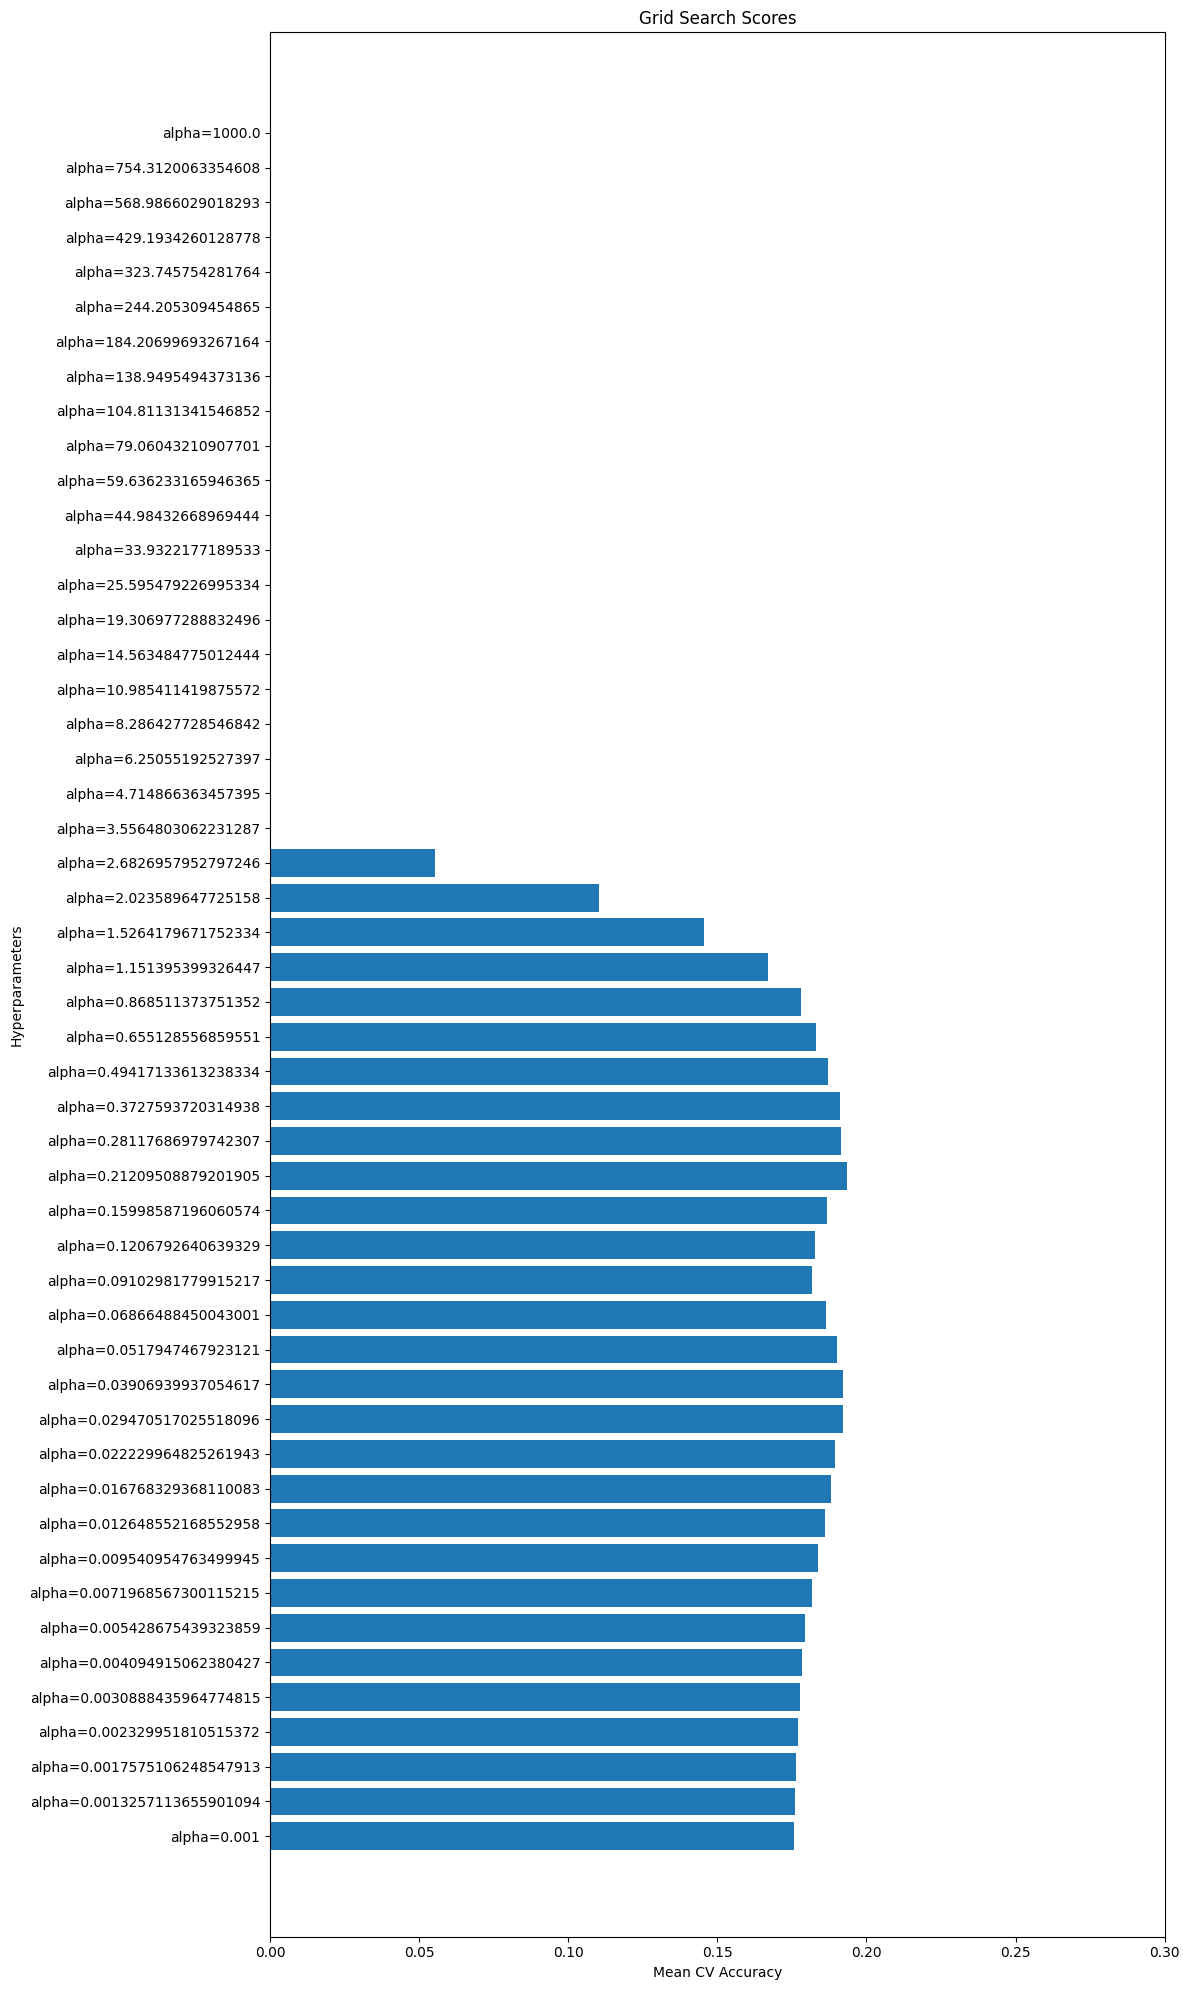

In [66]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = gs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Scores')
plt.xlim([0, 0.3])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

최적의 hyperparameter는 'alpha': 0.21209508879201905인 것을 확인 가능하며, best_estimator로 최적의 모델을 추출 후 train score, test score을 측정한다.

In [77]:
lasso = gs.best_estimator_
# lr.fit (X_train_poly_scaled, y_train)

lasso_score = [lasso.score(X_train_poly_scaled, y_train), lasso.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {lasso_score}")

train score, test score : [0.32730937516359737, 0.29353663055601364]


#### (3-2) random search

In [74]:
# lasso 모델 fit 및 train score, test score 출력
# 이때, 최적의 alpha를 찾기 위해 random search 기법 사용

from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

lasso = Lasso()

param_grid = {'alpha': uniform(0, 1000)}

rs = RandomizedSearchCV(lasso, param_grid, n_iter=100, n_jobs=-1)
rs.fit(X_train_poly_scaled, y_train)

print(f'최적의 hyperparameter : {rs.best_params_}')
print(f'cross-validation score : {rs.best_score_}')

최적의 hyperparameter : {'alpha': 2.001475534684438}
cross-validation score : 0.11194148119847902


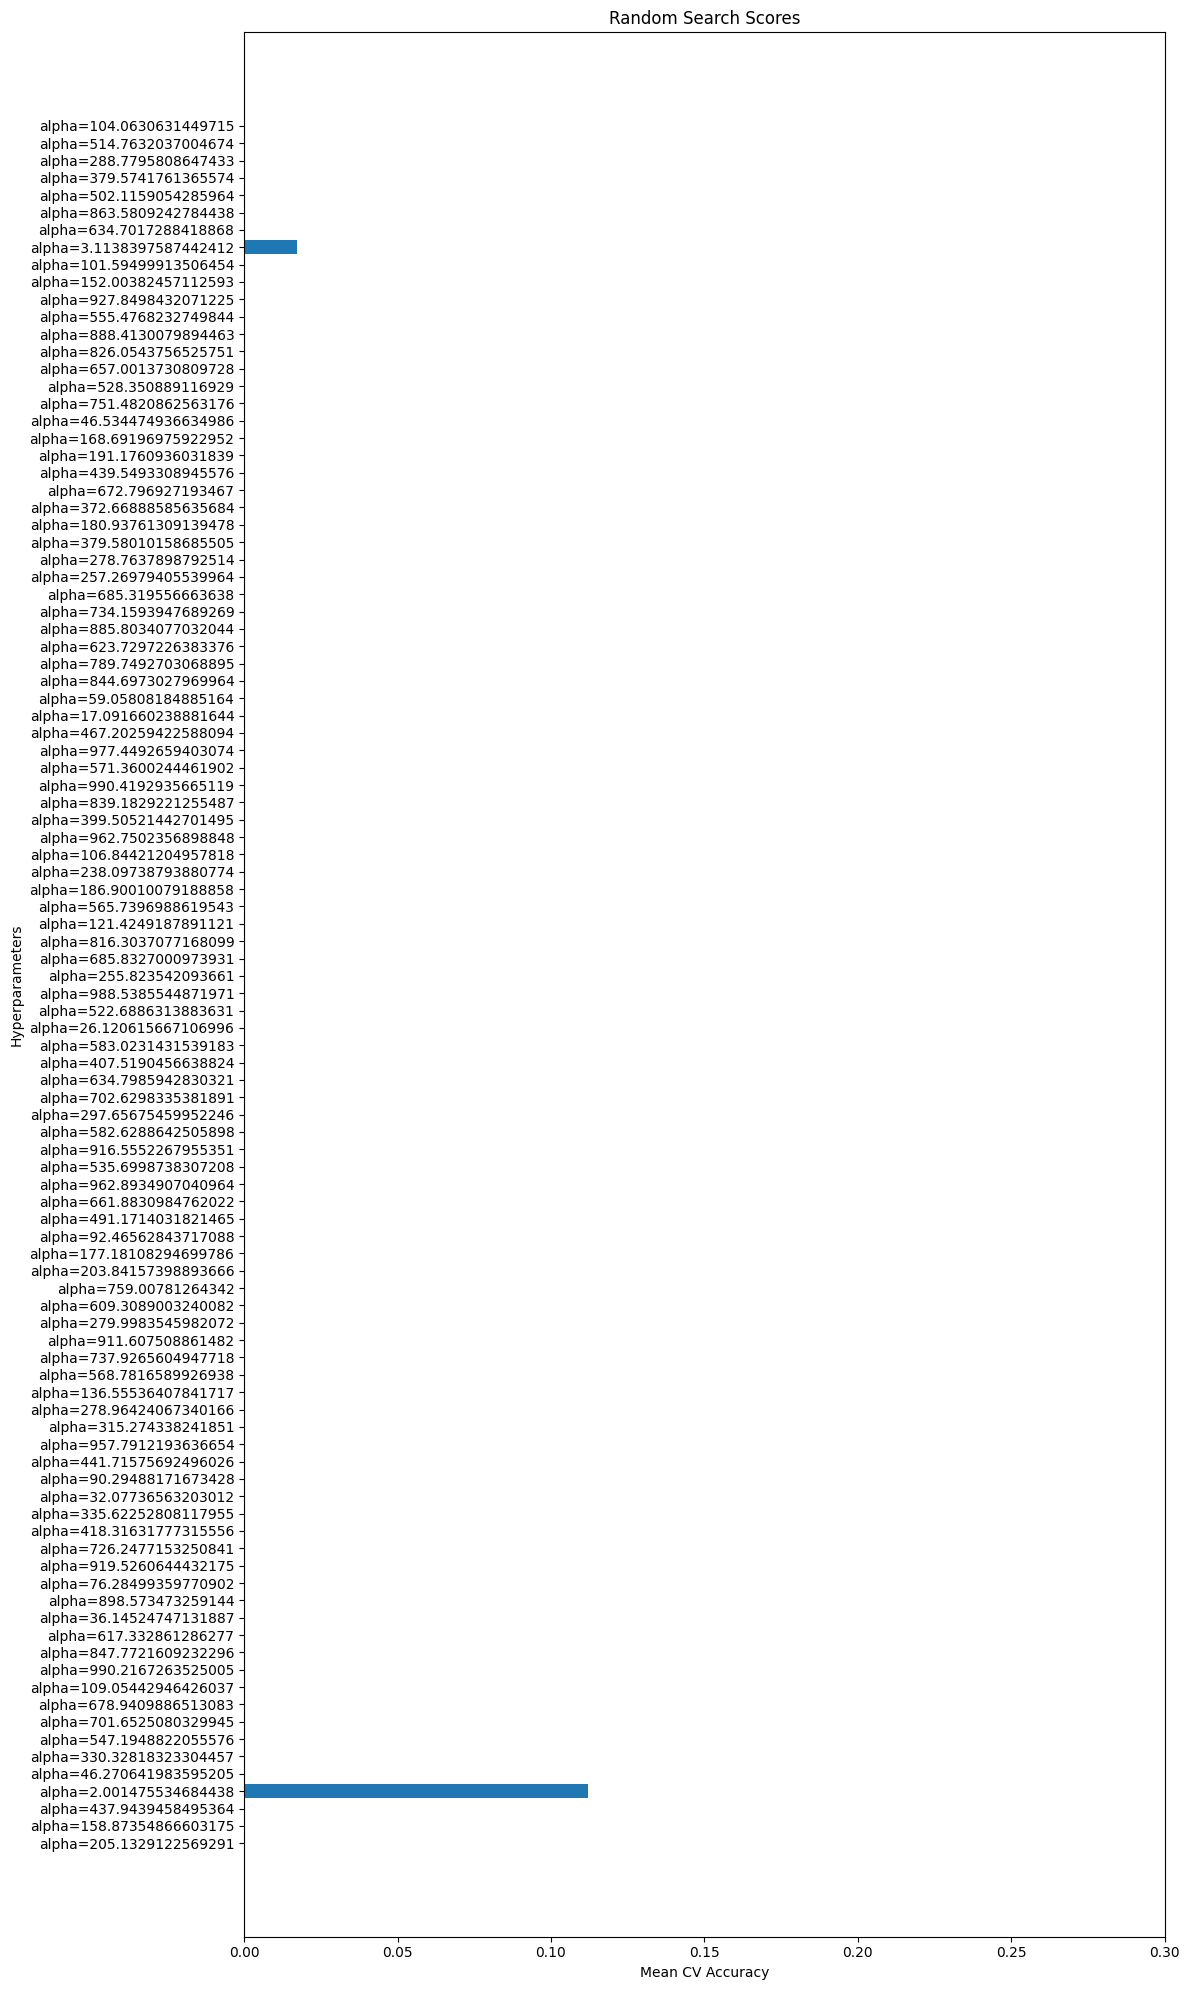

In [78]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
alpha_values = [params[i]['alpha'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"alpha={alpha}" for alpha in alpha_values])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim([0, 0.3])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

일단은 최적의 hyperparameter는 'alpha': 2.001475534684438인 것을 확인 가능하며, best_estimator로 최적의 모델을 추출 후 train score, test score을 측정한다.

참 신기한 건, validation score의 등장이 alpha 2개에서만 일어난다는 것이다.

In [79]:
lasso = rs.best_estimator_
# lr.fit (X_train_poly_scaled, y_train)

lasso_score = [lasso.score(X_train_poly_scaled, y_train), lasso.score(X_test_poly_scaled, y_test)]
print (f"train score, test score : {lasso_score}")

train score, test score : [0.12596174998155163, 0.12615833711310953]
